In [1]:
from mpl_toolkits.mplot3d import Axes3D
from rtree import index
import xgboost as xgb
import pickle
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

import keras
from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [2]:
%store -r mc_data

In [3]:
###### Data columns
i = 0
for val in mc_data.columns:
    print(i," ",val)
    i = i + 1

0   MCParticleID
1   MC_Hit_X
2   MC_Hit_Y
3   MC_Hit_Z
4   PrHit_LHCbID
5   PrHit_Xat0
6   PrHit_Zat0
7   PrHit_isX
8   PrHit_planeCode
9   PrHit_w2
10   PrHit_yMax
11   PrHit_yMin
12   PrHit_zone
13   event
14   hasT
15   isInUT
16   isInVelo
17   isLong
18   isLong_fromB
19   isLong_fromB_more5
20   isLong_more5


In [4]:
mc_hits = mc_data.values

In [5]:
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        xlayer_model = load_model('./models/xlayer_model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [6]:
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        xtrack_model = load_model('./models/xtrack_model.h5')

In [7]:
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        xlayer_model_next_layer = load_model('./models/xlayer_model_next_layer.h5')

In [8]:
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        tracks_classifier = load_model('./models/track_classifier_all_stations_v3.h5')

In [9]:
%store -r zLays
%store -r max_x
%store -r min_x
%store -r max_y
%store -r min_y
%store -r events

In [10]:
print(events)

[15837 15838 15839 15840 15841 15842 15843 15844 15845 15846 15847 15848
 15849 15850 15851 15852 15853 15854 15855 15856 15857 15858 15859 15860
 15861 15862 15863 15864 15865 15866 15867 15868 15869 15870 15871 15872
 15873 15874 15875 15876 15877 15878 15879 15880 15881 15882 15883 15884
 15885 15886 15887 15888 15889 15890 15891 15892 15893 15894 15895 15896
 15897 15898 15899 15900 15901 15902 15903 15904 15905 15906 15907 15908
 15909 15910 15911 15912 15913 15914 15915 15916 15917 15918 15919 15920
 15921 15922 15923 15924 15925 15926 15927 15928 15929 15930 15931 15932
 15933 15934 15935 15936 15937 15938 15939 15940 15941 17909 17910 17911
 17912 17913 17914 17915 17916 17917 17918 17919 17920 17921 17922 17923
 17924 17925 17926 17927 17928 17929 17930 17931 17932 17933 17934 17935
 17936 17937 17938 17939 17940 17941 17942 17943 17944 17945 17946 17947
 17948 17949 17950 17951 17952 17953 17954 17955 17956 17957 17958 17959
 17960 17961 17962 17963 17964 17965 17966 17967 17

In [11]:
def histogram(data, color, min, max, title, x_axis, y_axis):
    fig = plt.figure(figsize=(19, 10))
    ax = fig.add_subplot(111)
    
    textstr = '$\mu=%.3f$\n$\sigma=%.3f$\n$n=%.0f$'%(np.mean(np.array(data)), np.std(np.array(data)), len(data))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=18,
            verticalalignment='top', bbox=props)

    n, bins, patches = plt.hist(data, 100, facecolor=color, range=(min,max))
    ax.set_title('%s\n' % title)
    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis)
    ax.grid()
    plt.show()

In [12]:
def predictHeight(x0, x3, x_stereo, stereo_layer, first_layer, last_layer):
    
    z_stereo = zLays[stereo_layer]
    
    if (stereo_layer % 2 != 0):
        angle = 5
    else:
        angle = -5
    
    if (x3 - x0 == 0):
        m = 1
    else:
        m = float(zLays[last_layer] - zLays[first_layer]) / float(x3 - x0)
    n = zLays[last_layer] - (m * x3)
    
    x_pred = (z_stereo - n) / m 
    beta = (x_pred - x_stereo) / (math.radians(angle) * z_stereo)
    return math.tan(beta) * z_stereo

In [13]:
def predictMiddleHit(x0, x3, stereo_layer, first_layer, last_layer):
    z_stereo = zLays[stereo_layer]
    m = float(zLays[last_layer] - zLays[first_layer]) / float(x3 - x0)
    n = zLays[last_layer] - (m * x3)
    return (z_stereo - n) / m 

In [14]:
def validateTrack(track):
    found = 0
    if (not track is None):
        for id in np.unique(np.array(track[0][6])):
            tmp_found = 0
            if track[1][6][1] == id or track[1][6][2] == id and track[2][6][1] == id or track[2][6][2] == id:
                tmp_found += 1
            if track[1][6][0] == id or track[1][6][3] == id and track[2][6][0] == id or track[2][6][3] == id:
                tmp_found += 1
            if (tmp_found > 1):
                if (track[0][6][0] == id or track[0][6][3] == id) and (track[0][6][0] == id or track[0][6][3] == id):
                    found += 1
    return (found > 0)

In [15]:
def validTrackThird_NN(track1, track2, valid_tracks):
    max = 0
    selected = None
    if (len(valid_tracks) > 0):
        selected = valid_tracks[0]
        for track in valid_tracks:
            pred = tracks_classifier.predict(np.concatenate((track1[:6],track2[:6],track[:6])).reshape(1,-1))
            if (pred > max):
                max = pred
                selected = track
    return selected, max

In [16]:
def selectValidTracks_NN(valid_tracks):
    max = 0
    selected = None
    if (len(valid_tracks) > 0):
        selected = valid_tracks[0]
        for track in valid_tracks:
            pred = tracks_classifier.predict(np.concatenate((track[0][:6],track[1][:6],track[2][:6])).reshape(1,-1))
            if (pred > max):
                max = pred
                selected = track
    return (selected, max)

In [17]:
#
# Test the NN model by using events not feeded as train 
#

def trackReconstruction(hit_tree, station, track_tree):
    
    # Variable defining the maximum number of hits gathered from the R-trees when using the predicted value from the NN
    max_hits_gathered = 10

    # Range in which valid hits are look up in the first R-tree
    long_range = 200
    
    x0_layer = 0
    if (station == 1):
        x0_layer = 4
    elif station == 2:
        x0_layer = 8

    u_layer = x0_layer + 1
    v_layer = x0_layer + 2
    x1_layer = x0_layer + 3
    
    hits_station = list(hit_tree.intersection((min_x, max_x, x0_layer, x0_layer, 0, 1), objects='raw'))
        
    tracks = []    
    
    for hit in hits_station:

        first_hit = hit[1]
        zone = hit[2]

        predicted = (xlayer_model.predict(np.array([first_hit, x0_layer]).reshape(1,-1)))[0]
        mean_predicted = ((first_hit + predicted[0] + predicted[1] + predicted[2]) / 4)

        found = list(hit_tree.nearest((mean_predicted - long_range, mean_predicted + long_range, x1_layer, x1_layer, zone, zone), objects='raw'))
        found_layer3 = sorted(found, key=lambda x: np.abs(x[0]- mean_predicted))[:max_hits_gathered]
        arr_layer3 = np.unique(np.array(found_layer3), axis=0)

        found = list(hit_tree.nearest((mean_predicted - long_range, mean_predicted + long_range, v_layer, v_layer, zone, zone), objects='raw'))
        found_layer2 = sorted(found, key=lambda x: np.abs(x[0] - mean_predicted))[:max_hits_gathered]
        arr_layer2 = np.unique(np.array(found_layer2), axis=0)

        found = list(hit_tree.nearest((mean_predicted - long_range, mean_predicted + long_range, u_layer, u_layer, zone, zone), objects='raw'))
        found_layer1 = sorted(found, key=lambda x: np.abs(x[0] - mean_predicted))[:max_hits_gathered]
        arr_layer1 = np.unique(np.array(found_layer1), axis=0)

        # Now, for each hit found in the last layer, as it is the one with most precision, 
        # tracks are searched
        
        already = {}
        
        for h3 in arr_layer3:

            for h2 in arr_layer2:

                # Predict height for each hit selected in the V layer
                pred_h2 = predictHeight(first_hit, h3[1], h2[1], v_layer, x0_layer, x1_layer)

                if (pred_h2 > 0) and (pred_h2 > max_y) or (pred_h2 < 0) and (pred_h2 < min_y):
                    continue

                if (pred_h2 > 0) and h2[2] == 0 or (pred_h2 < 0) and h2[2] == 1:
                    continue
                    
                for h1 in arr_layer1:

                    # Predict height for hit in the U layer
                    pred_h1 = predictHeight(first_hit, h3[1], h1[1], u_layer, x0_layer, x1_layer)
                    if (pred_h1 > 0) and (pred_h1 > max_y) or (pred_h1 < 0) and (pred_h1 < min_y):
                        continue
                        
                    if (pred_h1 > 0) and h1[2] == 0 or (pred_h1 < 0) and h1[2] == 1:
                        continue
                        
                    if np.abs(pred_h2 - pred_h1) < 15.5:
                        max_h = pred_h2
                        min_h = pred_h1
                        if (pred_h1 > pred_h2):
                            max_h = pred_h1
                            min_h = pred_h2
                        track_tree.insert(int(first_hit), (first_hit, first_hit, min_h, max_h, station, station), [first_hit, h1[1], pred_h1, h2[1], pred_h2, h3[1], (hit[3],h1[3],h2[3],h3[3])])
    
    #histogram(X_diff, 'blue', -0.02, 0.02, 'Station %d' % station,'','')
    return tracks
    

In [461]:
import time
mean = done = ghosts = 0
test_events = events[:1]

p_hits = index.Property()
p_hits.dimension = 3

p_tracks = index.Property()
p_tracks.dimension = 3

X_real_data = []
X_fake_data = []

ghost_val = 0
total = 0

for event in test_events:
    particles_test_event = mc_hits[mc_hits[:,13] == event]
    mean_val = size_val = 0
    
    hit_tree = index.Index(properties=p_hits, interleaved=False)
    track_tree = index.Index(properties=p_tracks, interleaved=False)
    
    track_stations = [[],[],[]]        
    
    length_valid = 0
    for j in range(0, len(particles_test_event)):
        hit = particles_test_event[j]
        if (len(hit[5]) > 1) and (hit[0] != 11) and (hit[0] != -11):
            length_valid += 1
            for i in range(0,len(hit[5])):
                if (i > 0  and np.abs(hit[5][i] - hit[5][i - 1]) < 2):
                    continue
                hit_store = [hit[4][i], hit[5][i], hit[12][i], j]
                hit_tree.insert(int(hit[4][i]), (float(hit[5][i]), float(hit[5][i]), hit[8][i], hit[8][i], hit[12][i], hit[12][i]), hit_store)
    
    trackReconstruction(hit_tree, 0, track_tree)
    trackReconstruction(hit_tree, 1, track_tree)
    trackReconstruction(hit_tree, 2, track_tree)
    
    firstTracks = list(track_tree.intersection((min_x, max_x, min_y, max_y, 0, 0), objects='raw'))
    
    already = {}
    total_valid = 0
    ghost = 0
    start = time.time()
    
    mean = 0
    
    print(len(firstTracks))
    for track in firstTracks:
        
        if (not track[0] in already):
            already[track[0]] = []
        
        validTracks = []
        next_tracks = xtrack_model.predict(np.array([track[:6]]).reshape(1,-1))[0]
        
        min_h = next_tracks[1]
        max_h = next_tracks[2]
        if (min_h > max_h):
            min_h = max_h
            max_h = next_tracks[1]
        
        secondTracks = list(track_tree.intersection((next_tracks[0] - 150, next_tracks[0] + 150, min_h - 80, max_h + 80, 1, 1), objects='raw'))
        
        min_h = next_tracks[4]
        max_h = next_tracks[5]
        if (min_h > max_h):
            min_h = max_h
            max_h = next_tracks[4]
        thirdTracks = list(track_tree.nearest((next_tracks[3] - 150, next_tracks[3] + 150, min_h - 80, max_h + 80, 2, 2), objects='raw'))
        
        if (len(secondTracks) == 0):
            continue
        
        for secondTrack in secondTracks:
            selected, acc = validTrackThird_NN(track, secondTrack, thirdTracks)
            if not selected is None:
                validTracks.append([track, secondTrack, selected])
        
        final_track, acc = selectValidTracks_NN(validTracks)
        if not final_track is None:
            already[track[0]].append(final_track)
            #track_tree.delete(int(final_track[1][0]), (final_track[1][0], final_track[1][0], final_track[1][4], final_track[1][5], 1, 1))
            #track_tree.delete(int(final_track[2][0]), (final_track[2][0], final_track[2][0], final_track[2][4], final_track[2][5], 2, 2))

    
    end = time.time()
    print('Time to evaluate all tracks: %s' % (end - start))
    for key in already:
        tracks = already[key]
        final_track, acc = selectValidTracks_NN(tracks)
        if not final_track is None and acc > 0.7 : 
            if validateTrack(final_track):
                total_valid += 1
            else:
                ghost += 1
    
    
    print('Mean %s' % (mean/length_valid))
    mean_val += total_valid/length_valid
    ghost_val += ghost/length_valid
    done += 1
    
    print("Event %d/%d \t Acc: %f Ghost: %f" % (done,len(test_events), total_valid/length_valid, ghost/length_valid))
    
print("\nFinal Result:")
print("\t Mean: %f" % (mean_val/len(test_events)))
print("\t Ghosts: %f" % (ghost_val/len(test_events)))

214
Time to evaluate all tracks: 4.710608243942261
Mean 0.0
Event 1/1 	 Acc: 0.290698 Ghost: 0.127907

Final Result:
	 Mean: 0.290698
	 Ghosts: 0.127907


In [459]:
import time
mean = done = ghosts = 0
test_events = events[:1]

p_hits = index.Property()
p_hits.dimension = 3

p_tracks = index.Property()
p_tracks.dimension = 3

X_real_data = []
X_fake_data = []

ghost_val = 0
total = 0

for event in test_events:
    particles_test_event = mc_hits[mc_hits[:,13] == event]
    mean_val = size_val = 0
    
    hit_tree = index.Index(properties=p_hits, interleaved=False)
    track_tree = index.Index(properties=p_tracks, interleaved=False)
    
    track_stations = [[],[],[]]        
    
    length_valid = 0
    for j in range(0, len(particles_test_event)):
        hit = particles_test_event[j]
        if (len(hit[5]) > 1) and (hit[0] != 11) and (hit[0] != -11):
            length_valid += 1
            for i in range(0,len(hit[5])):
                if (i > 0  and np.abs(hit[5][i] - hit[5][i - 1]) < 2):
                    continue
                hit_store = [hit[4][i], hit[5][i], hit[12][i], j]
                hit_tree.insert(int(hit[4][i]), (float(hit[5][i]), float(hit[5][i]), hit[8][i], hit[8][i], hit[12][i], hit[12][i]), hit_store)
    
    trackReconstruction(hit_tree, 0, track_tree)
    trackReconstruction(hit_tree, 1, track_tree)
    trackReconstruction(hit_tree, 2, track_tree)
    
    firstTracks = list(track_tree.intersection((min_x, max_x, min_y, max_y, 0, 0), objects='raw'))
    
    already = {}
    total_valid = 0
    ghost = 0
    start = time.time()
    
    mean = 0
    
    print(len(firstTracks))
    for track in firstTracks:
        
        if (not track[0] in already):
            already[track[0]] = []
        
        validTracks = []
        next_layer = xlayer_model_next_layer.predict(np.array([track[0], track[1], track[3], track[5], 0]).reshape(1,-1))[0][0]

        min_h = track[2]
        max_h = track[4]
        if (min_h > max_h):
            min_h = max_h
            max_h = track[2]
        
        secondTracks = list(track_tree.intersection((next_layer - 200, next_layer + 200, min_h - 165, max_h + 165, 1, 1), objects='raw'))
        #secondTracks = sorted(secondTracks, key = lambda p: np.abs(p[0] - track[4]))[:10]
            
        mean += len(secondTracks)
        if (len(secondTracks) == 0):
            continue
        
        for secondTrack in secondTracks:
            
            min_h = secondTrack[2]
            max_h = secondTrack[4]
            if (min_h > max_h):
                min_h = max_h
                max_h = secondTrack[2]
            next_layer = xlayer_model_next_layer.predict(np.array([secondTrack[0], secondTrack[1], secondTrack[3], secondTrack[5], 4]).reshape(1,-1))[0][0]
            thirdTracks = list(track_tree.nearest((next_layer - 200, next_layer + 200, min_h - 165, max_h + 165, 2, 2), objects='raw'))
            
            if (len(thirdTracks) == 0):
                continue
            
            selected, acc = validTrackThird_NN(track, secondTrack, thirdTracks)
            if not selected is None:
                validTracks.append([track, secondTrack, selected])
        
        final_track, acc = selectValidTracks_NN(validTracks)
        if not final_track is None:
            already[track[0]].append(final_track)
            #track_tree.delete(int(final_track[1][0]), (final_track[1][0], final_track[1][0], final_track[1][4], final_track[1][5], 1, 1))
            #track_tree.delete(int(final_track[2][0]), (final_track[2][0], final_track[2][0], final_track[2][4], final_track[2][5], 2, 2))

    
    end = time.time()
    print('Time to evaluate all tracks: %s' % (end - start))
    for key in already:
        tracks = already[key]
        final_track, acc = selectValidTracks_NN(tracks)
        if not final_track is None and acc > 0.7 : 
            if validateTrack(final_track):
                total_valid += 1
            else:
                ghost += 1
    
    
    print('Mean %s' % (mean/length_valid))
    mean_val += total_valid/length_valid
    ghost_val += ghost/length_valid
    done += 1
    
    print("Event %d/%d \t Acc: %f Ghost: %f" % (done,len(test_events), total_valid/length_valid, ghost/length_valid))
    
print("\nFinal Result:")
print("\t Mean: %f" % (mean_val/len(test_events)))
print("\t Ghosts: %f" % (ghost_val/len(test_events)))

214
Time to evaluate all tracks: 14.415072917938232
Mean 22.430232558139537
Event 1/1 	 Acc: 0.325581 Ghost: 0.209302

Final Result:
	 Mean: 0.325581
	 Ghosts: 0.209302


In [ ]:
Particles with all hits
    All Hits:
        120 - 100
        Final Result:
             Mean: 0.761302
             Ghosts: 0.068680

        100 - 100
        Final Result:
             Mean: 0.759360
             Ghosts: 0.065982

        NN - v2
        Final Result:
             Mean: 0.779410
             Ghosts: 0.050571

    Long only:
        Final Result:
             Mean: 0.939262
             Ghosts: 0.008252

    Long P > 5 GeV/c
        Final Result:
             Mean: 0.965544
             Ghosts: 0.007200

    

In [ ]:
X_plot = []
Y_plot = []

event_hits = mc_hits[mc_hits[:,13] < events[1]]

# For each particle of a given event
for particle in event_hits:
    if (len(particle[5]) > 1):
        # Extract only 12 hits, as some of them are really close
        
        X_final = np.zeros(12)
        actual = -1
        for i in range(0, len(particle[5])):
            if (actual != particle[8][i]):
                X_final[actual + 1] = particle[5][i]
                actual = particle[8][i]
                
        if (X_final[3] == 0):
            continue
                
        next_tracks = xtrack_model.predict(np.array([track[:6]]).reshape(1,-1))[0]
        predicted = (xlayer_model.predict(np.array([X_final[0], 0]).reshape(1,-1)))[0]
        
        Y_plot.append(np.abs(predicted[2] - X_final[3]))
        #print("Range: %f Pred: %f Found: %d" % (search_range,predicted,found_bool))

histogram(Y_plot, 'orange', -200, 200, 'Slope X1-X0', '', '')

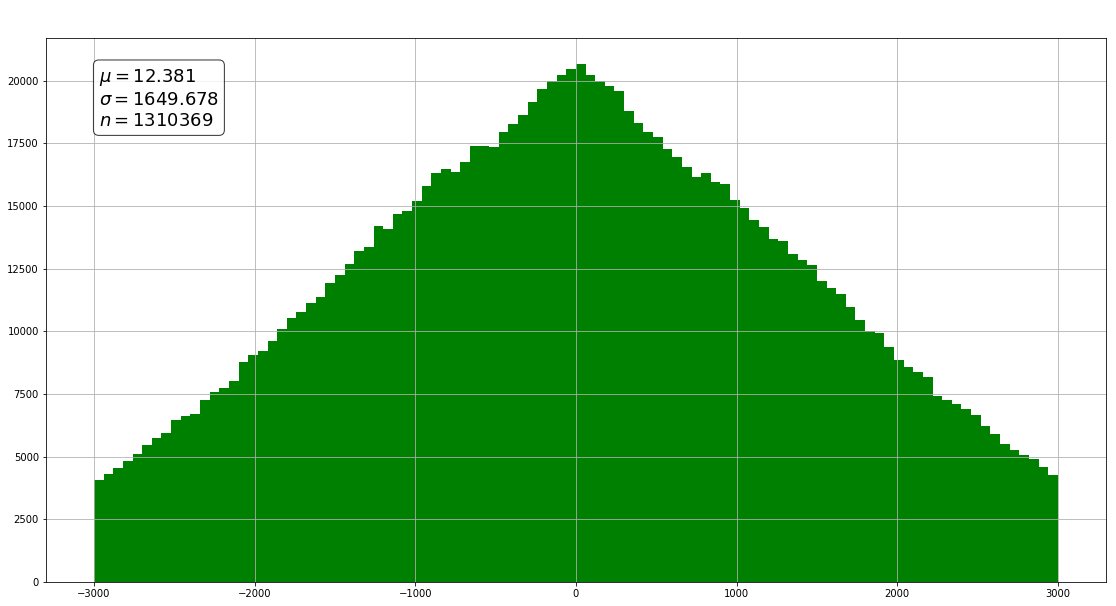

In [33]:
histogram(X_fake_data, 'green', -3000, 3000, '','','')

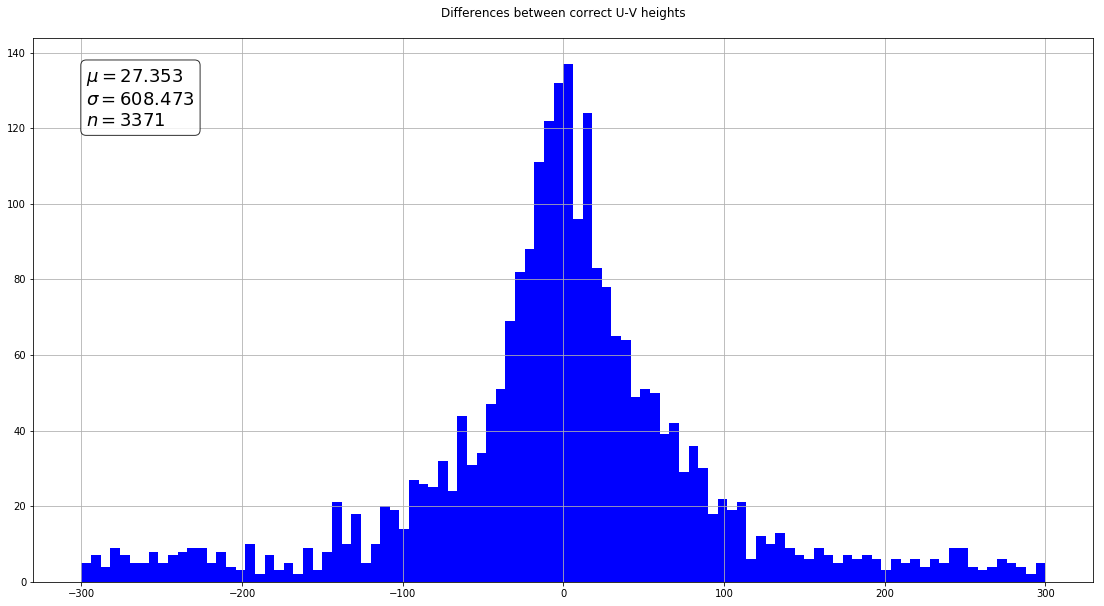

In [53]:
histogram(X_real_data, 'blue', -300, 300, 'Differences between correct U-V heights','','')

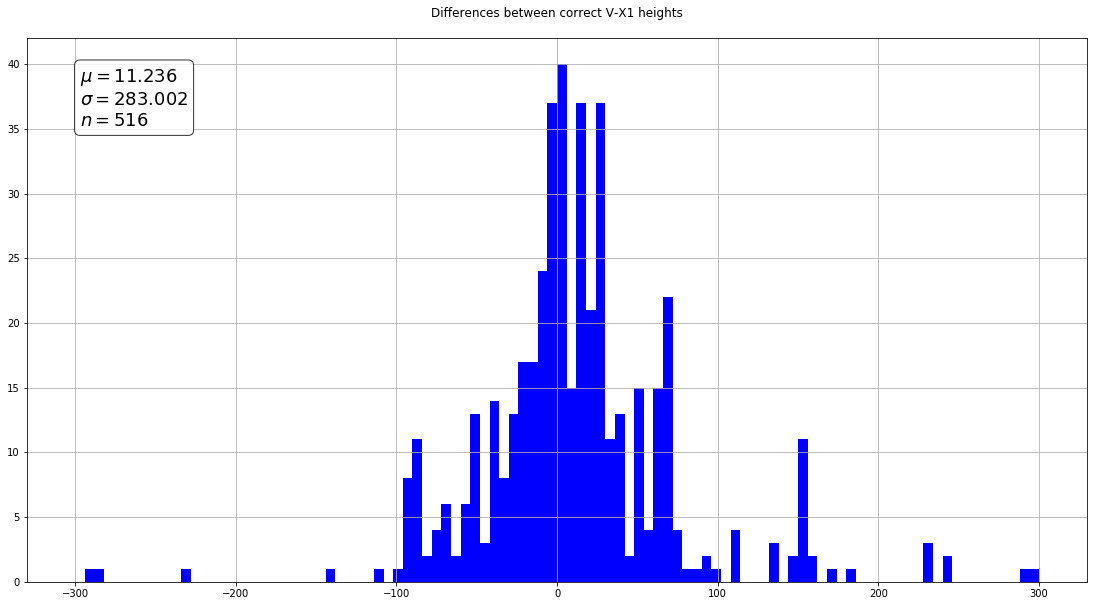

In [89]:
histogram(X_real_data, 'blue', -300, 300, 'Differences between correct V-X1 heights','','')